In [1]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
from datetime import timedelta

os.chdir("/Users/akilan/stock-forecasting-llm-aapl")
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

from src.data import load_data
from config import STOCK_SYMBOL, START_DATE, END_DATE
import requests


[*********************100%***********************]  1 of 1 completed


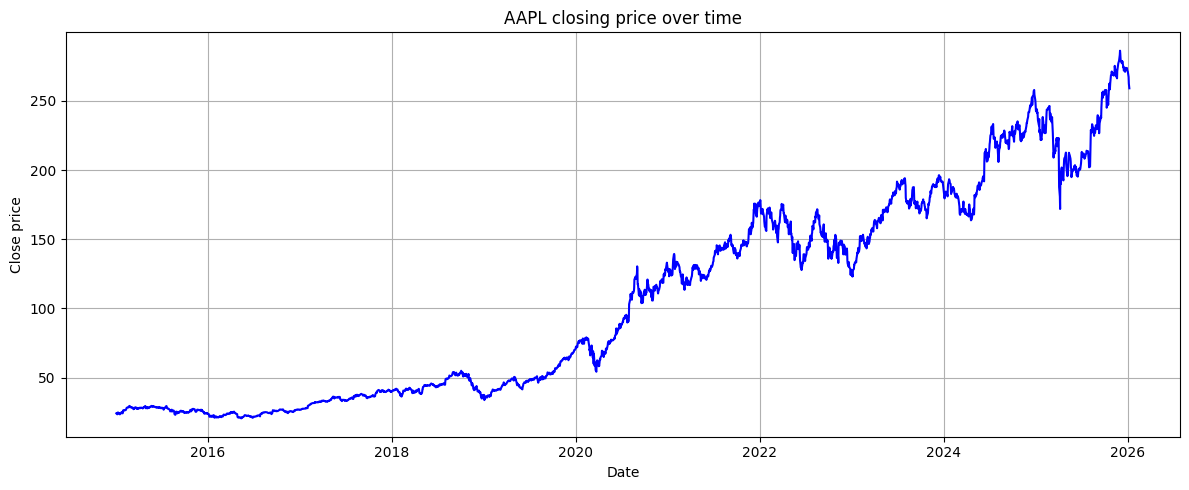

In [2]:
df_hist = load_data(STOCK_SYMBOL, START_DATE, END_DATE)
df_hist = df_hist.sort_index()

plt.figure(figsize=(12, 5))
plt.plot(df_hist.index, df_hist["Close"], color="blue")
plt.title(f"{STOCK_SYMBOL} closing price over time")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True)
plt.tight_layout()
plt.show()


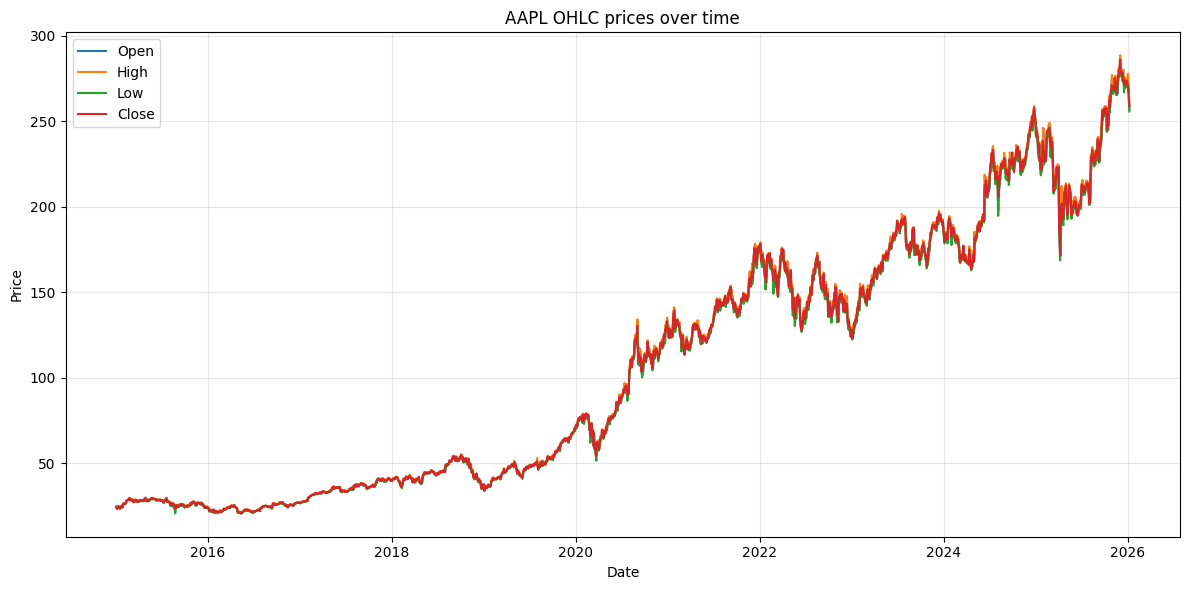

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df_hist.index, df_hist["Open"],  label="Open")
plt.plot(df_hist.index, df_hist["High"],  label="High")
plt.plot(df_hist.index, df_hist["Low"],   label="Low")
plt.plot(df_hist.index, df_hist["Close"], label="Close")
plt.title(f"{STOCK_SYMBOL} OHLC prices over time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


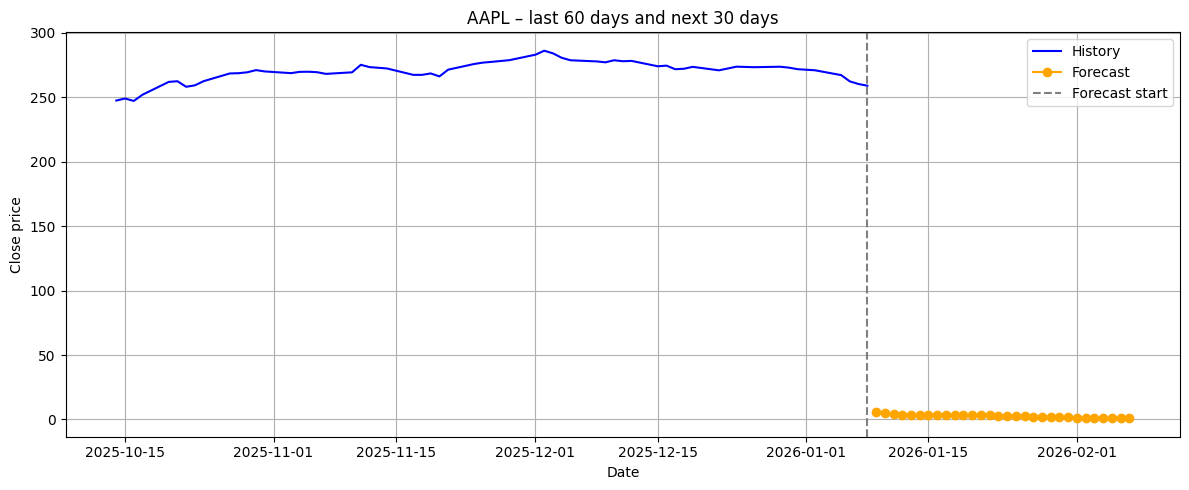

In [4]:
# assumes Docker FastAPI is running on port 8000
resp = requests.post(
    "http://localhost:8000/multi_horizon_forecast",
    json={"ticker": STOCK_SYMBOL, "days": 30},
)
data = resp.json()
horizons = data["horizons"]
forecasts = [(h["horizon"], h["forecast"]) for h in horizons]

def plot_30_day_forecast(df_hist, forecasts):
    df_tail = df_hist.sort_index().iloc[-60:]
    last_date = df_tail.index[-1]

    future_dates = [last_date + timedelta(days=h) for h, _ in forecasts]
    future_values = [v for _, v in forecasts]

    plt.figure(figsize=(12, 5))
    plt.plot(df_tail.index, df_tail["Close"], label="History", color="blue")
    plt.plot(future_dates, future_values, label="Forecast", color="orange", marker="o")
    plt.axvline(last_date, color="gray", linestyle="--", label="Forecast start")
    plt.title(f"{STOCK_SYMBOL} – last 60 days and next 30 days")
    plt.xlabel("Date")
    plt.ylabel("Close price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_30_day_forecast(df_hist, forecasts)


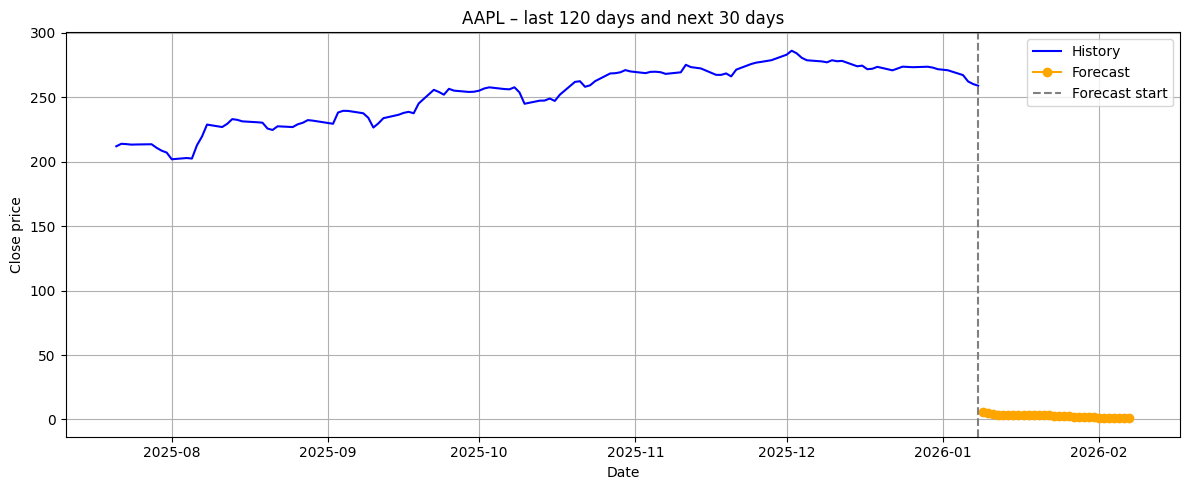

In [5]:
from datetime import timedelta
import matplotlib.pyplot as plt

def plot_forecast_timeseries(df_hist, forecasts, history_days=120):
    """
    df_hist: DataFrame with historical Close prices (DatetimeIndex).
    forecasts: list of (horizon, forecast_value) pairs, e.g. [(1, 195.3), ..., (30, 205.0)].
    history_days: how many past days to show before the forecast.
    """
    df_hist = df_hist.sort_index()
    df_tail = df_hist.iloc[-history_days:]          # last N days of history
    last_date = df_tail.index[-1]

    # Build future dates from horizons
    future_dates = [last_date + timedelta(days=h) for h, _ in forecasts]
    future_values = [v for _, v in forecasts]

    plt.figure(figsize=(12, 5))

    # Historical time series
    plt.plot(df_tail.index, df_tail["Close"], label="History", color="blue")

    # Forecast time series (continuation to the right)
    plt.plot(future_dates, future_values, label="Forecast", color="orange", marker="o")

    # Vertical line where forecast starts
    plt.axvline(last_date, color="gray", linestyle="--", label="Forecast start")

    plt.title(f"{STOCK_SYMBOL} – last {history_days} days and next {len(forecasts)} days")
    plt.xlabel("Date")
    plt.ylabel("Close price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# After you call the API and build `forecasts`, run:
plot_forecast_timeseries(df_hist, forecasts, history_days=120)


In [6]:
import matplotlib.pyplot as plt

def plot_ohlc_forecast(df_all, split_date):
    """
    df_all: combined dataframe with OHLC columns and 'type' column.
    split_date: last historical date (datetime).
    """
    df_all = df_all.sort_index()

    plt.figure(figsize=(14, 6))

    # Historical OHLC
    hist = df_all[df_all["type"] == "history"]
    plt.plot(hist.index, hist["Close"], color="blue",  label="Close (history)")
    plt.plot(hist.index, hist["High"],  color="green", alpha=0.5, label="High (history)")
    plt.plot(hist.index, hist["Low"],   color="red",   alpha=0.5, label="Low (history)")

    # Forecast OHLC
    fc = df_all[df_all["type"] == "forecast"]
    plt.plot(fc.index, fc["Close"], color="orange", marker="o", label="Close (forecast)")
    plt.plot(fc.index, fc["High"],  color="lime",   linestyle="--", alpha=0.7, label="High (forecast)")
    plt.plot(fc.index, fc["Low"],   color="salmon", linestyle="--", alpha=0.7, label="Low (forecast)")

    # Vertical line at forecast start
    plt.axvline(split_date, color="gray", linestyle="--", label="Forecast start")

    plt.title(f"{STOCK_SYMBOL} – OHLC history and forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
last_hist_date = df_hist.index[-1]
plot_ohlc_forecast(df_all, last_hist_date)


NameError: name 'df_all' is not defined

In [8]:
resp = requests.post(
    "http://localhost:8000/multi_horizon_forecast",
    json={"ticker": STOCK_SYMBOL, "days": 2},   # today + tomorrow
)
data = resp.json()
# assume: [{"horizon": 0, "forecast": value_today}, {"horizon": 1, "forecast": value_tomorrow}, ...]
forecasts = [(h["horizon"], h["forecast"]) for h in data["horizons"]]


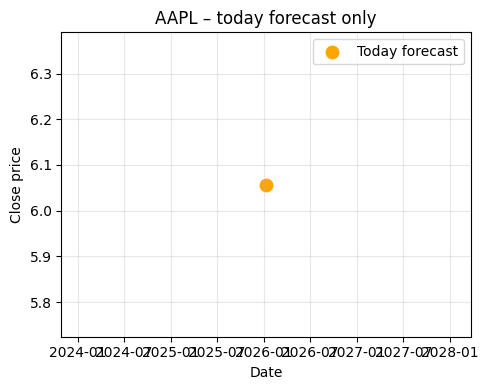

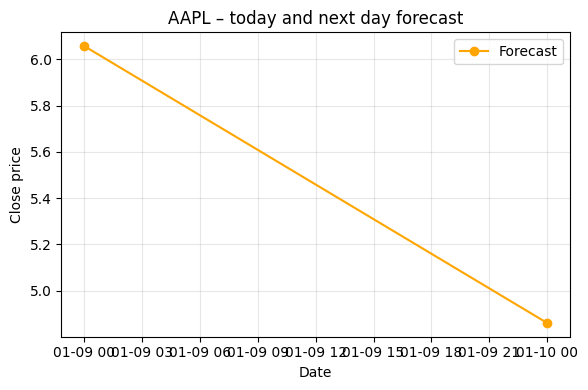

In [9]:
import matplotlib.pyplot as plt
from datetime import timedelta

df_hist = df_hist.sort_index()
last_real_date = df_hist.index[-1]

# pick today forecast (horizon 1)
today_h, today_val = forecasts[0]   # adjust index if your first item is not today
today_date = last_real_date + timedelta(days=today_h)

plt.figure(figsize=(5, 4))
plt.scatter([today_date], [today_val], color="orange", s=80, label="Today forecast")
plt.title(f"{STOCK_SYMBOL} – today forecast only")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# take today and next day
today_h, today_val = forecasts[0]
next_h, next_val   = forecasts[1]

today_date = last_real_date + timedelta(days=today_h)
next_date  = last_real_date + timedelta(days=next_h)

dates  = [today_date, next_date]
values = [today_val, next_val]

plt.figure(figsize=(6, 4))
plt.plot(dates, values, marker="o", color="orange", label="Forecast")
plt.title(f"{STOCK_SYMBOL} – today and next day forecast")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


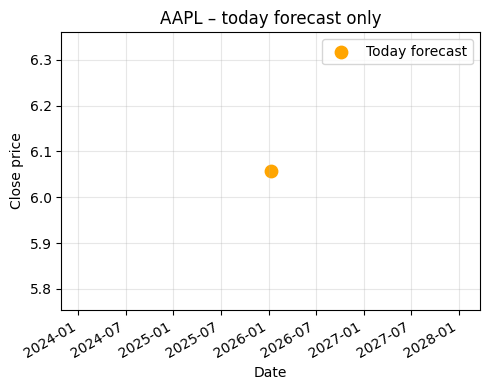

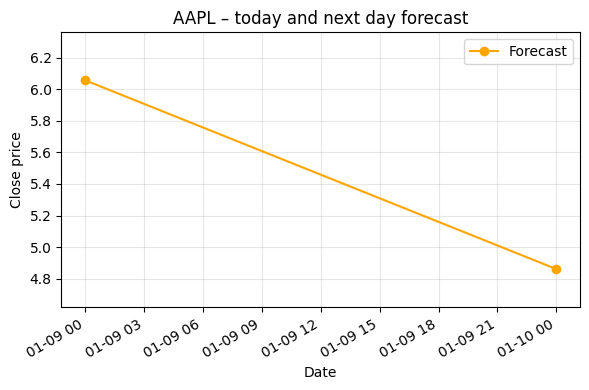

In [10]:
from datetime import timedelta
import numpy as np
import pandas as pd
import requests

# 1) Historical data (already loaded in your notebook)
df_hist = load_data(STOCK_SYMBOL, START_DATE, END_DATE)
df_hist = df_hist.sort_index()

last_real_date = df_hist.index[-1]

# 2) Call your FastAPI forecast (example: 30 days, but we use first 2)
resp = requests.post(
    "http://localhost:8000/multi_horizon_forecast",
    json={"ticker": STOCK_SYMBOL, "days": 30},
)
data = resp.json()
raw_forecasts = [(h["horizon"], h["forecast"]) for h in data["horizons"]]  # list[(h, value)]

# 3) OPTIONAL: inverse scale if your model used a scaler
# Comment this block out if your forecasts are already real prices.
# Example for a MinMaxScaler that was fit on Close column only:
#
# close_vals = np.array([v for _, v in raw_forecasts]).reshape(-1, 1)
# close_real = scaler.inverse_transform(close_vals).flatten()
# forecasts = [(h, v) for (h, _), v in zip(raw_forecasts, close_real)]

# If you DON'T have a scaler handy, just use raw values:
forecasts = raw_forecasts
import matplotlib.pyplot as plt

# Assume horizon 1 is "today"
today_h, today_val = forecasts[0]
today_date = last_real_date + timedelta(days=today_h)

plt.figure(figsize=(5, 4))
plt.scatter([today_date], [today_val], color="orange", s=80, label="Today forecast")

plt.title(f"{STOCK_SYMBOL} – today forecast only")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True, alpha=0.3)
plt.legend()

# make axes tight and dates readable
plt.gcf().autofmt_xdate()
plt.ylim(today_val * 0.95, today_val * 1.05)

plt.tight_layout()
plt.show()
# Take first two horizons: today and next day
today_h, today_val = forecasts[0]
next_h, next_val   = forecasts[1]

today_date = last_real_date + timedelta(days=today_h)
next_date  = last_real_date + timedelta(days=next_h)

dates  = [today_date, next_date]
values = [today_val, next_val]

plt.figure(figsize=(6, 4))
plt.plot(dates, values, marker="o", color="orange", label="Forecast")

plt.title(f"{STOCK_SYMBOL} – today and next day forecast")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True, alpha=0.3)
plt.legend()

plt.gcf().autofmt_xdate()
plt.ylim(min(values) * 0.95, max(values) * 1.05)

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# 5‑minute candles for multiple days
df = pd.read_csv("data/intraday_aapl_5min.csv", parse_dates=["datetime"])
df = df.sort_values("datetime").set_index("datetime")

# Keep OHLC; you can add volume later
df = df[["open", "high", "low", "close"]]

# Optional: filter a date range
# df = df["2025-10-01":"2025-12-31"]
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale each feature 0–1
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df.values)  # shape (T, 4)

seq_len = 20  # use last 20 candles (~100 minutes) to predict next one

X, y = [], []
for i in range(len(scaled_values) - seq_len):
    X.append(scaled_values[i:i+seq_len])         # 20 x 4
    y.append(scaled_values[i+seq_len])           # next candle (4 dims)

X = np.array(X)  # (N, 20, 4)
y = np.array(y)  # (N, 4)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, 4)),
    LSTM(32),
    Dense(16, activation="relu"),
    Dense(4)  # output: [open, high, low, close]
])

model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es],
    verbose=1,
)
import datetime as dt

def forecast_intraday_day(df, model, scaler, seq_len, target_date, freq="5min"):
    """
    df: original intraday OHLC dataframe (index=datetime).
    target_date: date (yyyy-mm-dd string) to forecast (e.g. '2026-01-09').
    Returns a dataframe of predicted OHLC for that date at freq.
    """
    target_date = pd.to_datetime(target_date).date()

    # trading window for a day (adjust times for your market)
    start_time = dt.time(9, 0)
    end_time   = dt.time(16, 0)

    # last seq_len candles before target_date 9:00
    start_dt = pd.Timestamp.combine(target_date, start_time)
    prev_window = df[df.index < start_dt].iloc[-seq_len:]
    if len(prev_window) < seq_len:
        raise ValueError("Not enough history before target date")

    hist_scaled = scaler.transform(prev_window.values)  # seq_len x 4
    window = hist_scaled.copy()

    # timestamps for the forecast day at given frequency
    future_index = pd.date_range(
        start=start_dt,
        end=pd.Timestamp.combine(target_date, end_time),
        freq=freq
    )

    preds_scaled = []
    for _ in range(len(future_index)):
        inp = window[-seq_len:]  # last seq_len steps
        pred = model.predict(inp[np.newaxis, ...], verbose=0)[0]  # (4,)
        preds_scaled.append(pred)
        window = np.vstack([window, pred])

    preds_scaled = np.array(preds_scaled)  # (steps, 4)
    preds = scaler.inverse_transform(preds_scaled)

    return pd.DataFrame(preds, index=future_index, columns=["open", "high", "low", "close"])
# assume df contains up to yesterday's real intraday data
last_date = df.index[-1].date()

today_date = (last_date + dt.timedelta(days=1)).strftime("%Y-%m-%d")
tomorrow_date = (last_date + dt.timedelta(days=2)).strftime("%Y-%m-%d")

today_forecast = forecast_intraday_day(df, model, scaler, seq_len, today_date)
tomorrow_forecast = forecast_intraday_day(df, model, scaler, seq_len, tomorrow_date)

today_forecast.head(), tomorrow_forecast.head()

import matplotlib.pyplot as plt

def plot_intraday_ohlc(forecast_df, title):
    plt.figure(figsize=(12, 5))
    plt.plot(forecast_df.index, forecast_df["close"], label="Close", color="blue")
    plt.fill_between(
        forecast_df.index,
        forecast_df["low"],
        forecast_df["high"],
        color="lightblue",
        alpha=0.3,
        label="High–Low range",
    )
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_intraday_ohlc(today_forecast,  f"{STOCK_SYMBOL} – today intraday OHLC forecast")
plot_intraday_ohlc(tomorrow_forecast, f"{STOCK_SYMBOL} – tomorrow intraday OHLC forecast")


FileNotFoundError: [Errno 2] No such file or directory: 'data/intraday_aapl_5min.csv'

[*********************100%***********************]  1 of 1 completed


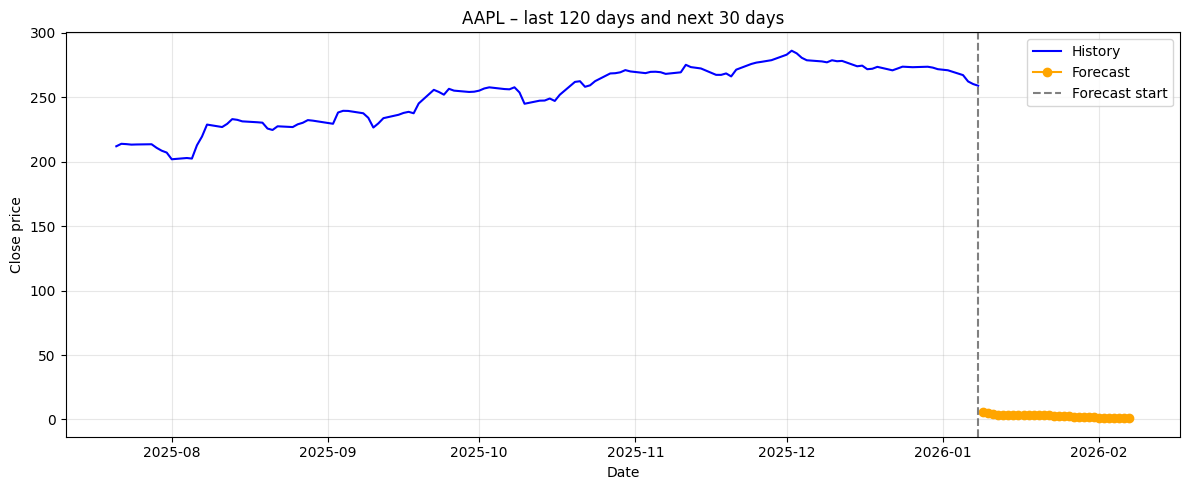

In [12]:
import matplotlib.pyplot as plt
from datetime import timedelta
import requests

# 1) Historical daily data
df_hist = load_data(STOCK_SYMBOL, START_DATE, END_DATE).sort_index()

# 2) Call FastAPI for 30‑day forecast
resp = requests.post(
    "http://localhost:8000/multi_horizon_forecast",
    json={"ticker": STOCK_SYMBOL, "days": 30},
)
data = resp.json()
forecasts = [(h["horizon"], h["forecast"]) for h in data["horizons"]]

# 3) Build future dates
last_date = df_hist.index[-1]
future_dates = [last_date + timedelta(days=h) for h, _ in forecasts]
future_values = [v for _, v in forecasts]

# 4) Plot history + forecast
plt.figure(figsize=(12, 5))
plt.plot(df_hist.index[-120:], df_hist["Close"].iloc[-120:], label="History", color="blue")
plt.plot(future_dates, future_values, label="Forecast", color="orange", marker="o")
plt.axvline(last_date, color="gray", linestyle="--", label="Forecast start")
plt.title(f"{STOCK_SYMBOL} – last 120 days and next 30 days")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Build a simple future_df using forecast Close for next 30 days
future_df = pd.DataFrame(
    {
        "Open":  future_values,   # until you have real OHLC forecasts
        "High":  future_values,
        "Low":   future_values,
        "Close": future_values,
    },
    index=pd.DatetimeIndex(future_dates),
)

ohlc_cols = ["Open", "High", "Low", "Close"]

df_hist_plot = df_hist[ohlc_cols].copy()
df_hist_plot["type"] = "history"

future_df_plot = future_df[ohlc_cols].copy()
future_df_plot["type"] = "forecast"

df_all = pd.concat([df_hist_plot, future_df_plot])


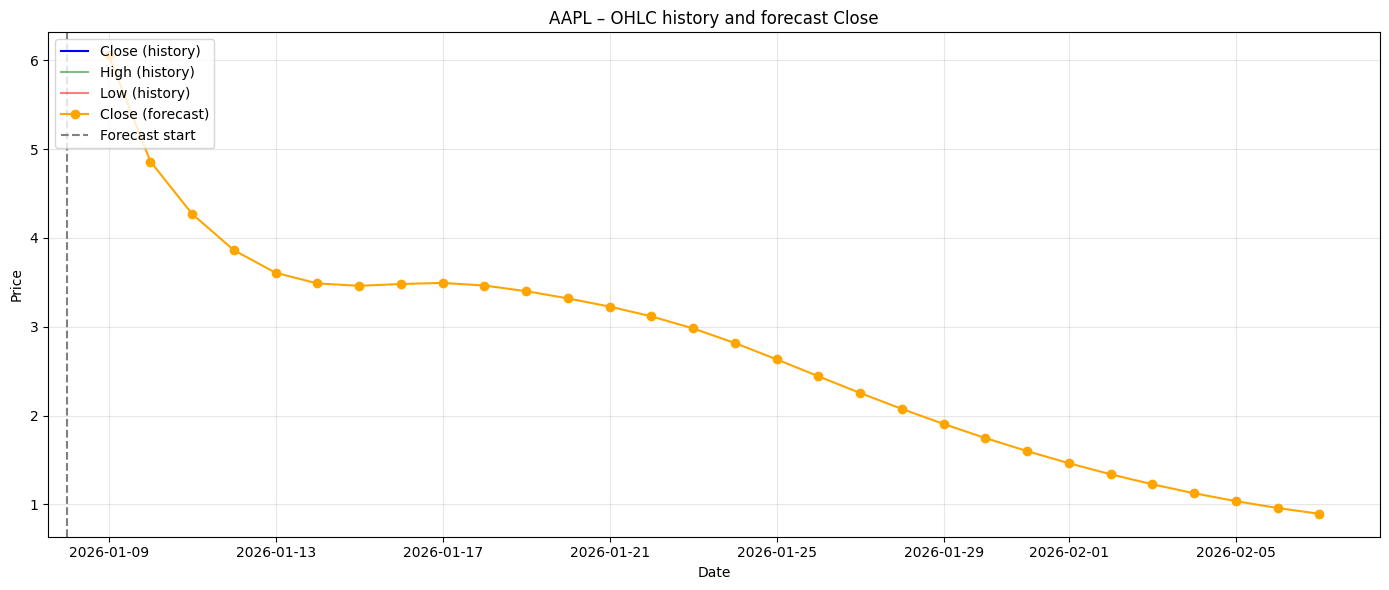

In [15]:
def plot_ohlc_forecast(df_all, split_date):
    df_all = df_all.sort_index()
    plt.figure(figsize=(14, 6))

    hist = df_all[df_all["type"] == "history"]
    plt.plot(hist.index, hist["Close"], color="blue",  label="Close (history)")
    plt.plot(hist.index, hist["High"],  color="green", alpha=0.5, label="High (history)")
    plt.plot(hist.index, hist["Low"],   color="red",   alpha=0.5, label="Low (history)")

    fc = df_all[df_all["type"] == "forecast"]
    plt.plot(fc.index, fc["Close"], color="orange", marker="o", label="Close (forecast)")

    plt.axvline(split_date, color="gray", linestyle="--", label="Forecast start")

    plt.title(f"{STOCK_SYMBOL} – OHLC history and forecast Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
last_hist_date = df_hist.index[-1]
plot_ohlc_forecast(df_all, last_hist_date)
    


In [16]:
import requests
from datetime import timedelta
import pandas as pd

# Historical daily data
df_hist = load_data(STOCK_SYMBOL, START_DATE, END_DATE).sort_index()
last_real_date = df_hist.index[-1]

# Ask API for 2 days (today + tomorrow)
resp = requests.post(
    "http://localhost:8000/multi_horizon_forecast",
    json={"ticker": STOCK_SYMBOL, "days": 2},
)
data = resp.json()
# assume: [{"horizon": 1, "forecast": ...}, {"horizon": 2, "forecast": ...}]
forecasts = [(h["horizon"], h["forecast"]) for h in data["horizons"]]

# Build a tiny forecast DataFrame for today & tomorrow
dates = [last_real_date + timedelta(days=h) for h, _ in forecasts]
values = [v for _, v in forecasts]

future_df = pd.DataFrame(
    {
        "Open":  values,   # placeholder until you have real OHLC forecasts
        "High":  values,
        "Low":   values,
        "Close": values,
    },
    index=pd.DatetimeIndex(dates),
)
today_date, tomorrow_date = future_df.index[0], future_df.index[1]


[*********************100%***********************]  1 of 1 completed


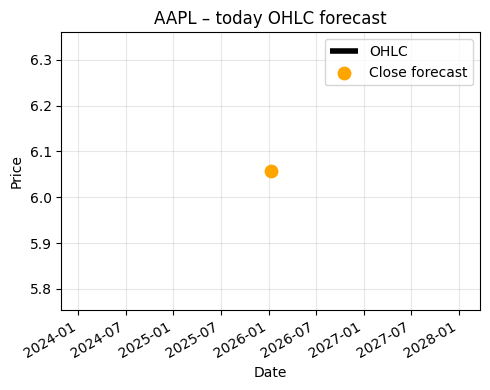

In [17]:
import matplotlib.pyplot as plt

def plot_today_ohlc(f_df, date):
    row = f_df.loc[date]

    plt.figure(figsize=(5, 4))

    # OHLC "candle" (here all equal, but structure is realistic)
    plt.vlines(date, row["Low"], row["High"], color="black", linewidth=4, label="OHLC")
    plt.scatter([date], [row["Close"]], color="orange", s=80, zorder=3, label="Close forecast")

    plt.title(f"{STOCK_SYMBOL} – today OHLC forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.ylim(row["Close"] * 0.95, row["Close"] * 1.05)
    plt.tight_layout()
    plt.show()

plot_today_ohlc(future_df, today_date)

